In [2]:
import Pkg

#Pkg.add("Optimisers")

using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
using CSV
using Random
using DataFrames
using Optimisers
using Statistics
using Plots


In [4]:
sunspot_data = CSV.read("Sunspot_data.csv", DataFrame)

sunspots = sunspot_data[:, 3];

In [5]:
function create_sequences(data, seq_len)
    X, y = [], []
    for i in 1:(length(data) - seq_len)
        push!(X, data[i:i+seq_len-1])
        push!(y, data[i+seq_len])
    end
    return hcat(X...), y  # Convert to matrix form
end

seq_len = 50  # Lookback window
X, y = create_sequences(sunspots, seq_len)

# Normalize
X = (X .- mean(X)) ./ std(X)
y = (y .- mean(y)) ./ std(y)

train_ratio = 0.8


split_var = Int(train_ratio * size(X, 2))

X_train, y_train = X[:, 1:split_var], y[1:split_var]
X_test, y_test = X[:, split_var+1:end], y[split_var+1:end]

X_train = reshape(X_train, size(X_train, 1), 1, size(X_train, 2))
X_test = reshape(X_test, size(X_test, 1), 1, size(X_test, 2))

y_train = reshape(y_train, 1, length(y_train))  # Convert to (1, batch_size)
y_test = reshape(y_test, 1, length(y_test))    # Convert to (1, batch_size)
;

In [6]:
model = Chain(
    Conv((5,), 1=>16, relu),
    MaxPool((2,)),
    Conv((3,), 16=>32, relu),
    MaxPool((2,)),
    Flux.flatten,
    Dense(320, 64, relu),  # Use 320 instead of 32
    Dense(64, 10, relu),
    Dense(10, 1),
     )    # Output a single prediction)
;

In [7]:
epochs = 100
batch_size = 64;

In [8]:
opt = ADAM()

data_loader = Flux.DataLoader((X_train, y_train), batchsize=batch_size, shuffle=true)

# Initialize optimizer state
opt_state = Flux.setup(opt, model)  

total_loss = []

for epoch in 1:epochs
    epoch_loss = 0
    for (x, y) in data_loader
        gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  
        Flux.update!(opt_state, Flux.trainable(model), gs)
        epoch_loss += Flux.Losses.mse(model(x), y)
    end
    println("Epoch $epoch - Train Loss: $epoch_loss")
    push!(total_loss, epoch_loss)
end


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Conv((5,), 1 => 16, relu)  # 96 parameters
│   summary(x) = "50×1×64 Array{Float64, 3}"
└ @ Flux ~/.julia/packages/Flux/3711C/src/layers/stateless.jl:60


Epoch 1 - Train Loss: 10.016235976305945
Epoch 2 - Train Loss: 5.777541394259773
Epoch 3 - Train Loss: 5.272931717511142
Epoch 4 - Train Loss: 4.819319651375557
Epoch 5 - Train Loss: 4.614827876193951
Epoch 6 - Train Loss: 4.662248846709592
Epoch 7 - Train Loss: 4.472635090684451
Epoch 8 - Train Loss: 4.1961278206696475
Epoch 9 - Train Loss: 4.194527806841641
Epoch 10 - Train Loss: 3.9920017998416504
Epoch 11 - Train Loss: 3.897979987443328
Epoch 12 - Train Loss: 3.739383518174862
Epoch 13 - Train Loss: 3.683220813170417
Epoch 14 - Train Loss: 3.721058922042768
Epoch 15 - Train Loss: 3.3950358089760706
Epoch 16 - Train Loss: 3.2550752075019935
Epoch 17 - Train Loss: 3.1740980037466997
Epoch 18 - Train Loss: 3.058257853507041
Epoch 19 - Train Loss: 2.902373401963062
Epoch 20 - Train Loss: 3.025442375094753
Epoch 21 - Train Loss: 2.9150397227763216
Epoch 22 - Train Loss: 2.6791554502766304
Epoch 23 - Train Loss: 2.6402436921284904
Epoch 24 - Train Loss: 2.55003766579612
Epoch 25 - Train 

In [9]:
preds = model(X_test);


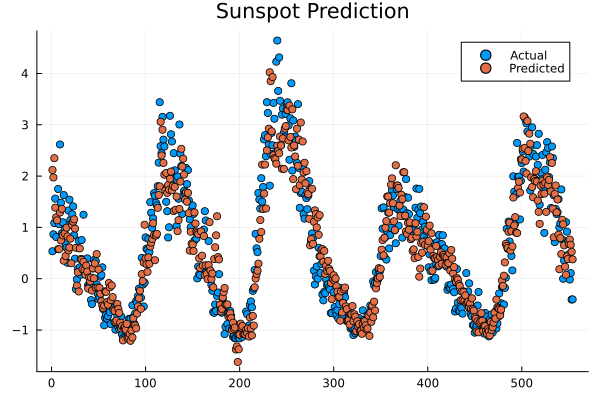

In [10]:
scatter(1:length(y_test[1, :]), y_test[1, :], label="Actual", title="Sunspot Prediction")
scatter!(1:length(preds[1, :]), preds[1, :], label="Predicted")

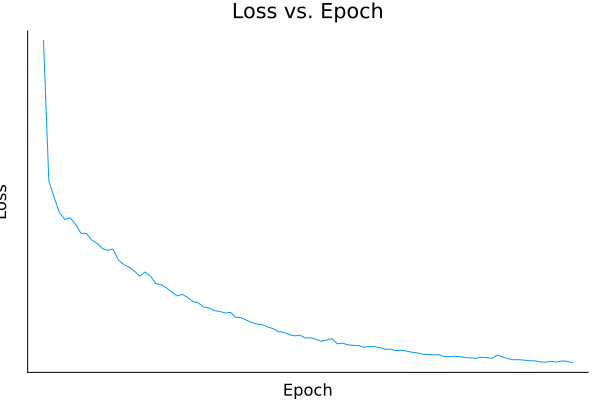

In [11]:
p1 = plot(1:epochs, total_loss, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)